In [2]:
"""Scatter neutrinos using density matrices.

Note: the functions expect states to have complex datatypes.

Created 17 October 2023.
"""
import numpy as np
from numpy import pi, cos, arccos
from scipy.linalg import logm


def random_scatter(initial_states, n, *args, **kwargs):
    """Scatter random pairs of particles `n` times and return all the states
     along the way."""
    N = len(initial_states)
    particle1, particle2 = pick_random_pairs(N, n)
    relative_angles = random_theta(n)

    states = np.array(initial_states)
    yield states

    for i, (p1, p2, theta) in enumerate(zip(particle1, particle2, relative_angles)):
        states = states.copy()
        states[[p1, p2]] = independent_scatter(*states[[p1, p2]], theta=theta, *args, **kwargs)
        yield states


def independent_scatter(rho1, rho2, *args, **kwargs):
    """Scatter two independent neutrinos, then return each of their new
    independent density matrices."""
    rho_full = combine_rho(rho1, rho2)
    rho_full = scatter(rho_full, *args, **kwargs)
    rho1, rho2 = split_rho(rho_full)
    return rho1, rho2


def scatter_backgrounds(rho0, rho_background, n, *args, **kwargs):
    """Scatter a neutrino of interest off of background neutrinos `n` times."""
    # The `theta` angle of a spherically uniform random 3D direction.
    cos_theta = 2*np.random.rand(n) - 1
    theta = arccos(cos_theta)

    rho = np.array(rho0)
    yield rho

    for theta_ in theta:
        rho = scatter_background(rho, rho_background, *args, theta=theta_, **kwargs)
        yield rho


def scatter_background(rho, rho_background, *args, **kwargs):
    """Scatter a neutrino of interest with (2x2) density matrix `rho` off of a
    background neutrino with *independent* (2x2) density matrix
    `rho_background`, and return the new density matrix for the neutrino of
    interest."""
    rho_full = combine_rho(rho, rho_background)
    rho_full = scatter(rho_full, *args, **kwargs)
    rho = trace_out(rho_full)

    return rho


def scatter(rho, theta=pi/2, omega0_t=0.1):
    """Evolve the flavor density matrix of two neutrinos that scatter."""
    phase = np.exp(-2j * omega0_t * (1 - cos(theta)))

    # Time evolution matrix.
    N = 2
    N_states = 2
    U = np.zeros(2 * N * [N_states], dtype=complex)
    U[0, 0, 0, 0] = U[1, 1, 1, 1] = phase
    U[0, 1, 0, 1] = U[1, 0, 1, 0] = (phase + 1) / 2
    U[0, 1, 1, 0] = U[1, 0, 0, 1] = (phase - 1) / 2

    rho = matmul(matmul(U, rho), dagger(U))  # TODO

    # This step is required in order to avoid floating point error that quickly
    # blows up (after ~50 scatters).
    trace = np.trace(np.trace(rho, axis1=0, axis2=2))
    rho /= trace

    return rho


def combine_rho(rho1, rho2):
    """Combine `rho1` and `rho2` into `rho` via a tensor product."""
    return np.moveaxis(np.tensordot(rho1, rho2, axes=0), 1, 2)


def split_rho(rho):
    """Obtain each neutrino's density matrix by tracing out the other."""
    rho1 = np.trace(rho, axis1=1, axis2=3)
    rho2 = np.trace(rho, axis1=0, axis2=2)
    return rho1, rho2


def matmul(A, B):
    """Multiply two (2, 2, 2, 2) arrays as if they were (4, 4) matrices."""
    return np.einsum('ijkl,klmn', A, B)


def dagger(A):
    """Find the Hermitian conjugate of a (2, 2, 2, 2) array as if it was a
    (4, 4) matrix."""
    return np.moveaxis(A, (0, 1), (2, 3)).conjugate()


def trace_out(rho):
    """Take the trace with respect to the second neutrino."""
    return np.trace(rho, axis1=1, axis2=3)


def flavor_expval(rho):
    return rho[1, 1].real


def entropy(rho):
    return - np.trace(rho @ logm(rho)).real


def pick_random_pairs(N, shape):
    """Pick two random (different) integers in [0, `N`)."""
    # Any random choice.
    choice1 = np.random.randint(0, N, shape)

    # A random choice that's different from choice 1.
    choice2 = (choice1 + np.random.randint(1, N, shape)) % N

    return choice1, choice2


def random_theta(shape):
    """Return the `theta` angles of spherically uniform random 3D directions."""
    cos_theta = 2*np.random.rand(shape) - 1
    theta = arccos(cos_theta)

    return theta


In [3]:
M = 10
n = 10000

initial_states = np.array(M * [[[1, 0], [0, 0]]] + M * [[[0, 0], [0, 1]]], dtype=complex)
states = np.array(list(random_scatter(initial_states, n)))

In [4]:
states

array([[[[1.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],

        [[1.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],

        [[1.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],

        ...,

        [[0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 1.        +0.00000000e+00j]],

        [[0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 1.        +0.00000000e+00j]],

        [[0.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 1.        +0.00000000e+00j]]],


       [[[1.        +0.00000000e+00j, 0.        +0.00000000e+00j],
         [0.        +0.00000000e+00j, 0.        +0.00000000e+00j]],

        [[1.        +0.00000000e

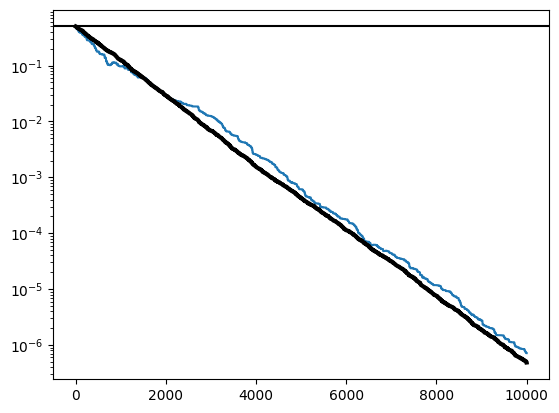

In [15]:
import matplotlib.pyplot as plt

plt.plot(states[..., 0, 0, 0] - 0.5)
plt.plot(states[..., :M, 0, 0].mean(axis=-1) - 0.5, lw=3, c='black')
# plt.plot(states[..., M:, 0, 0].mean(axis=-1), lw=3, c='black')
plt.axhline(1/2, c='black')
plt.yscale('log')
# plt.ylim(1/2 - 1e-3, 1/2 + 1e-3)
# plt.xlim(0, 10000)